In [1]:
import scanpy as sc
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os, sys
from scipy.io import mmread
import scipy.sparse as sp
from IPython.display import Image
from cnmf import cNMF

In [2]:
sc.settings.verbosity = 1  
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 10.3.0
asttokens           NA
backcall            0.2.0
cnmf                1.5.4
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
exceptiongroup      1.2.1
executing           0.8.3
fastcluster         1.2.6
h5py                3.11.0
importlib_resources NA
ipykernel           6.28.0
jedi                0.18.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.42.0
matplotlib          3.8.4
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.1
numpy               1.26.4
packaging           24.0
pandas              2.2.2
parso               0.8.3
patsy               0.5.6
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.10.0
prompt_toolkit      3.0.43
psutil              5.9.0
ptyprocess       

In [3]:
tms_adata = sc.read_h5ad("./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_senescent_cells.h5ad")
gene_list = sc.read_h5ad("./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes.h5ad").var_names
tms_adata.X = tms_adata.layers["raw_counts"]
tms_adata = tms_adata[:,gene_list]
tms_adata

View of AnnData object with n_obs × n_vars = 53305 × 3792
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'age', 'sex', 'ethnicity', 'sample_number', 'Donors', 'Age', 'Sex', 'Ethnicity', 'Race', 'BMI (kg/m2)', 'Downtime (min)', 'Cause of Death', 'Tobacco ( > 20 pack-years)', 'Alcohol', 'IV Drug abuse', 'Diabetes', 'Cancer', 'Hypertension', 'Coronary Artery Disease', 'Other noted conditions', 'donor_tissue_celltype', 'tissue_celltype', 'donor_tissue_broadcelltype', 'tissue_broadcelltype', 'CDKN2A+ MKI67-', 'broader_ce

In [4]:
freq_table = tms_adata.obs.drop_duplicates(subset=["donor", "tissue", "Sex"]).groupby(["tissue", "Sex"]).size().reset_index(name='count')
freq_table["tissue_Sex"] = freq_table["tissue"].astype(str) + "_" + freq_table["Sex"].astype(str)
tissue_sex_filter = freq_table[freq_table["count"] > 1].tissue_Sex.values
tissue_sex_filter

/tmp/ipykernel_1351455/558152723.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_table = tms_adata.obs.drop_duplicates(subset=["donor", "tissue", "Sex"]).groupby(["tissue", "Sex"]).size().reset_index(name='count')


array(['Bladder_F', 'Bladder_M', 'Blood_F', 'Blood_M', 'Bone_Marrow_F',
       'Bone_Marrow_M', 'Eye_F', 'Fat_F', 'Fat_M', 'Heart_F', 'Heart_M',
       'Large_Intestine_F', 'Large_Intestine_M', 'Liver_M', 'Lung_F',
       'Lung_M', 'Lymph_Node_F', 'Lymph_Node_M', 'Mammary_F', 'Muscle_F',
       'Muscle_M', 'Ovary_F', 'Pancreas_F', 'Prostate_M',
       'Salivary_Gland_F', 'Salivary_Gland_M', 'Skin_F', 'Skin_M',
       'Small_Intestine_F', 'Small_Intestine_M', 'Spleen_F', 'Spleen_M',
       'Stomach_F', 'Thymus_F', 'Thymus_M', 'Tongue_F', 'Tongue_M',
       'Trachea_F', 'Trachea_M', 'Uterus_F', 'Vasculature_F',
       'Vasculature_M'], dtype=object)

In [5]:
tms_adata = tms_adata[tms_adata.obs["tissue_Sex"].isin(tissue_sex_filter)]
tms_adata

View of AnnData object with n_obs × n_vars = 48114 × 3792
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'age', 'sex', 'ethnicity', 'sample_number', 'Donors', 'Age', 'Sex', 'Ethnicity', 'Race', 'BMI (kg/m2)', 'Downtime (min)', 'Cause of Death', 'Tobacco ( > 20 pack-years)', 'Alcohol', 'IV Drug abuse', 'Diabetes', 'Cancer', 'Hypertension', 'Coronary Artery Disease', 'Other noted conditions', 'donor_tissue_celltype', 'tissue_celltype', 'donor_tissue_broadcelltype', 'tissue_broadcelltype', 'CDKN2A+ MKI67-', 'broader_ce

In [8]:
# tms_adata = sc.read_h5ad("./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes.h5ad")
# tms_adata.X = sp.csr_matrix(tms_adata.X)
tms_adata.write_h5ad("./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_by_donor_tissue_celltype_cNMF_input1.h5ad")
tms_adata = sc.read_h5ad("./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_by_donor_tissue_celltype_cNMF_input1.h5ad")
tms_adata.shape

(48114, 3792)

In [9]:
## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = '/hpc/projects/group.quake/mmantri/tabula_immunosenescence/tabula_sapiens/cNMF/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc'
package_path = "/hpc/mydata/madhav.mantri/conda_envs/cnmf/lib/python3.9/site-packages/cnmf/cnmf.py"


In [10]:
# Path to the filtered counts dataset we output previously
countfn = "/hpc/projects/group.quake/mmantri/tabula_immunosenescence/tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_by_donor_tissue_celltype_cNMF_input1.h5ad"

In [11]:
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)

In [12]:
cnmf_obj.prepare(counts_fn=countfn, components=np.arange(10,50), n_iter=10, seed=14, num_highvar_genes=tms_adata.shape[1])


/hpc/mydata/madhav.mantri/conda_envs/cnmf/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
## Using GNU parallel
## This took 4 minutes in our testing
numworkers = 72
factorize_cmd = 'nohup parallel python ' + package_path + ' factorize --output-dir ' + output_directory + ' --name ' + run_name + ' --worker-index {} ::: ' + " ".join([str(x) for x in range(numworkers)]) + ' > ' + run_name + '.out'
print('Factorize command to simultaneously run factorization over %d cores using GNU parallel:\n%s' % (numworkers, factorize_cmd))
#!{factorize_cmd}

Factorize command to simultaneously run factorization over 72 cores using GNU parallel:
nohup parallel python /hpc/mydata/madhav.mantri/conda_envs/cnmf/lib/python3.9/site-packages/cnmf/cnmf.py factorize --output-dir /hpc/projects/group.quake/mmantri/tabula_immunosenescence/tabula_sapiens/cNMF/ --name TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc --worker-index {} ::: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 > TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc.out


In [75]:
# ## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
# cnmf_obj.factorize(worker_i=0, total_workers=1)

In [14]:
cnmf_obj.combine()

Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizat

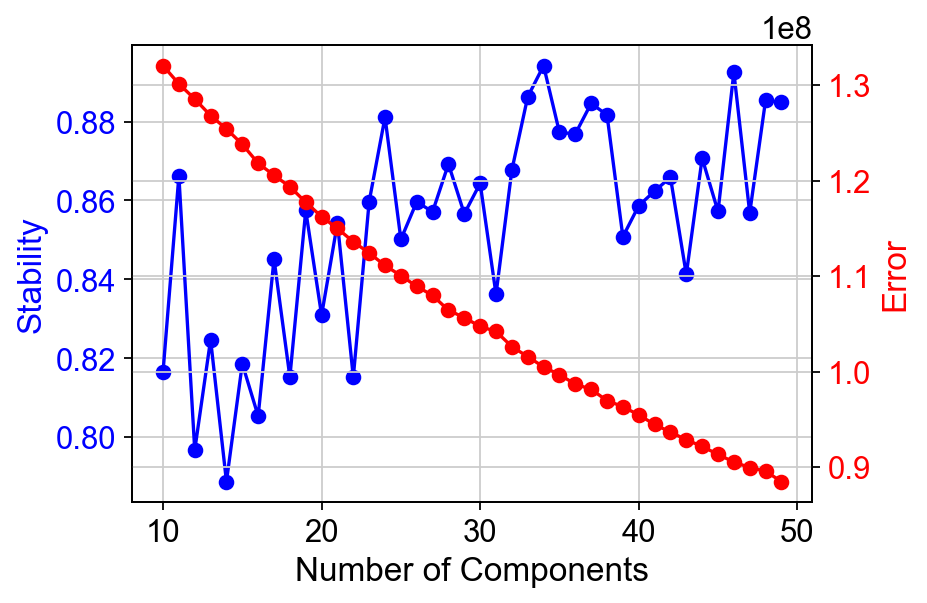

In [15]:
cnmf_obj.k_selection_plot(close_fig=False)

In [34]:
adata = sc.read(countfn)
# adata.X = adata.X.astype(np.float64)

In [36]:
sc.pp.normalize_total(adata, target_sum=1e4) ## TPT normalization
sc.pp.log1p(adata)

(48114, 3792)


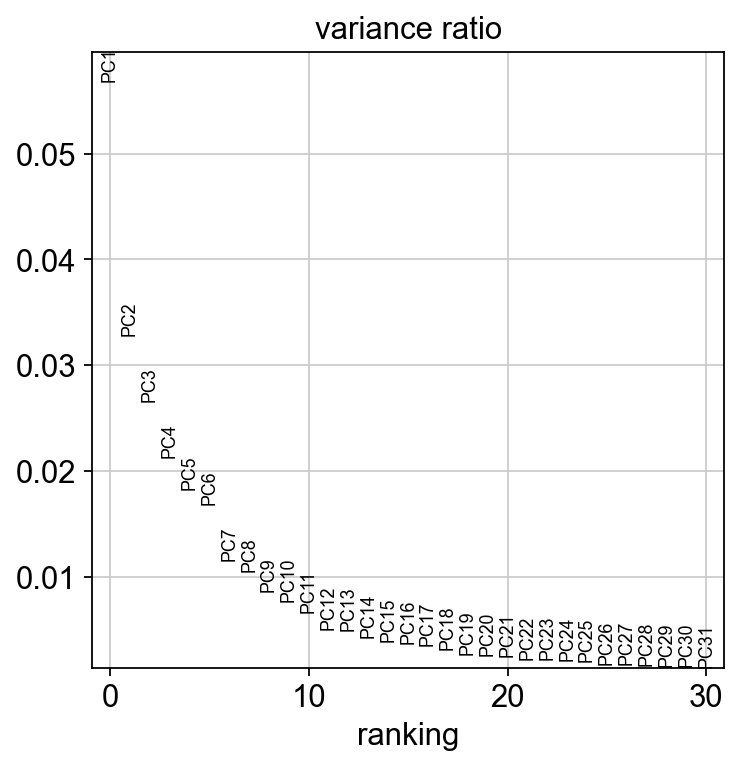

In [42]:
adata.raw = adata.copy()
sc.pp.scale(adata, max_value=10)
print(adata.shape)
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata, log=False)

In [46]:
selected_K = 34
density_threshold = 2.00

/hpc/mydata/madhav.mantri/conda_envs/cnmf/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


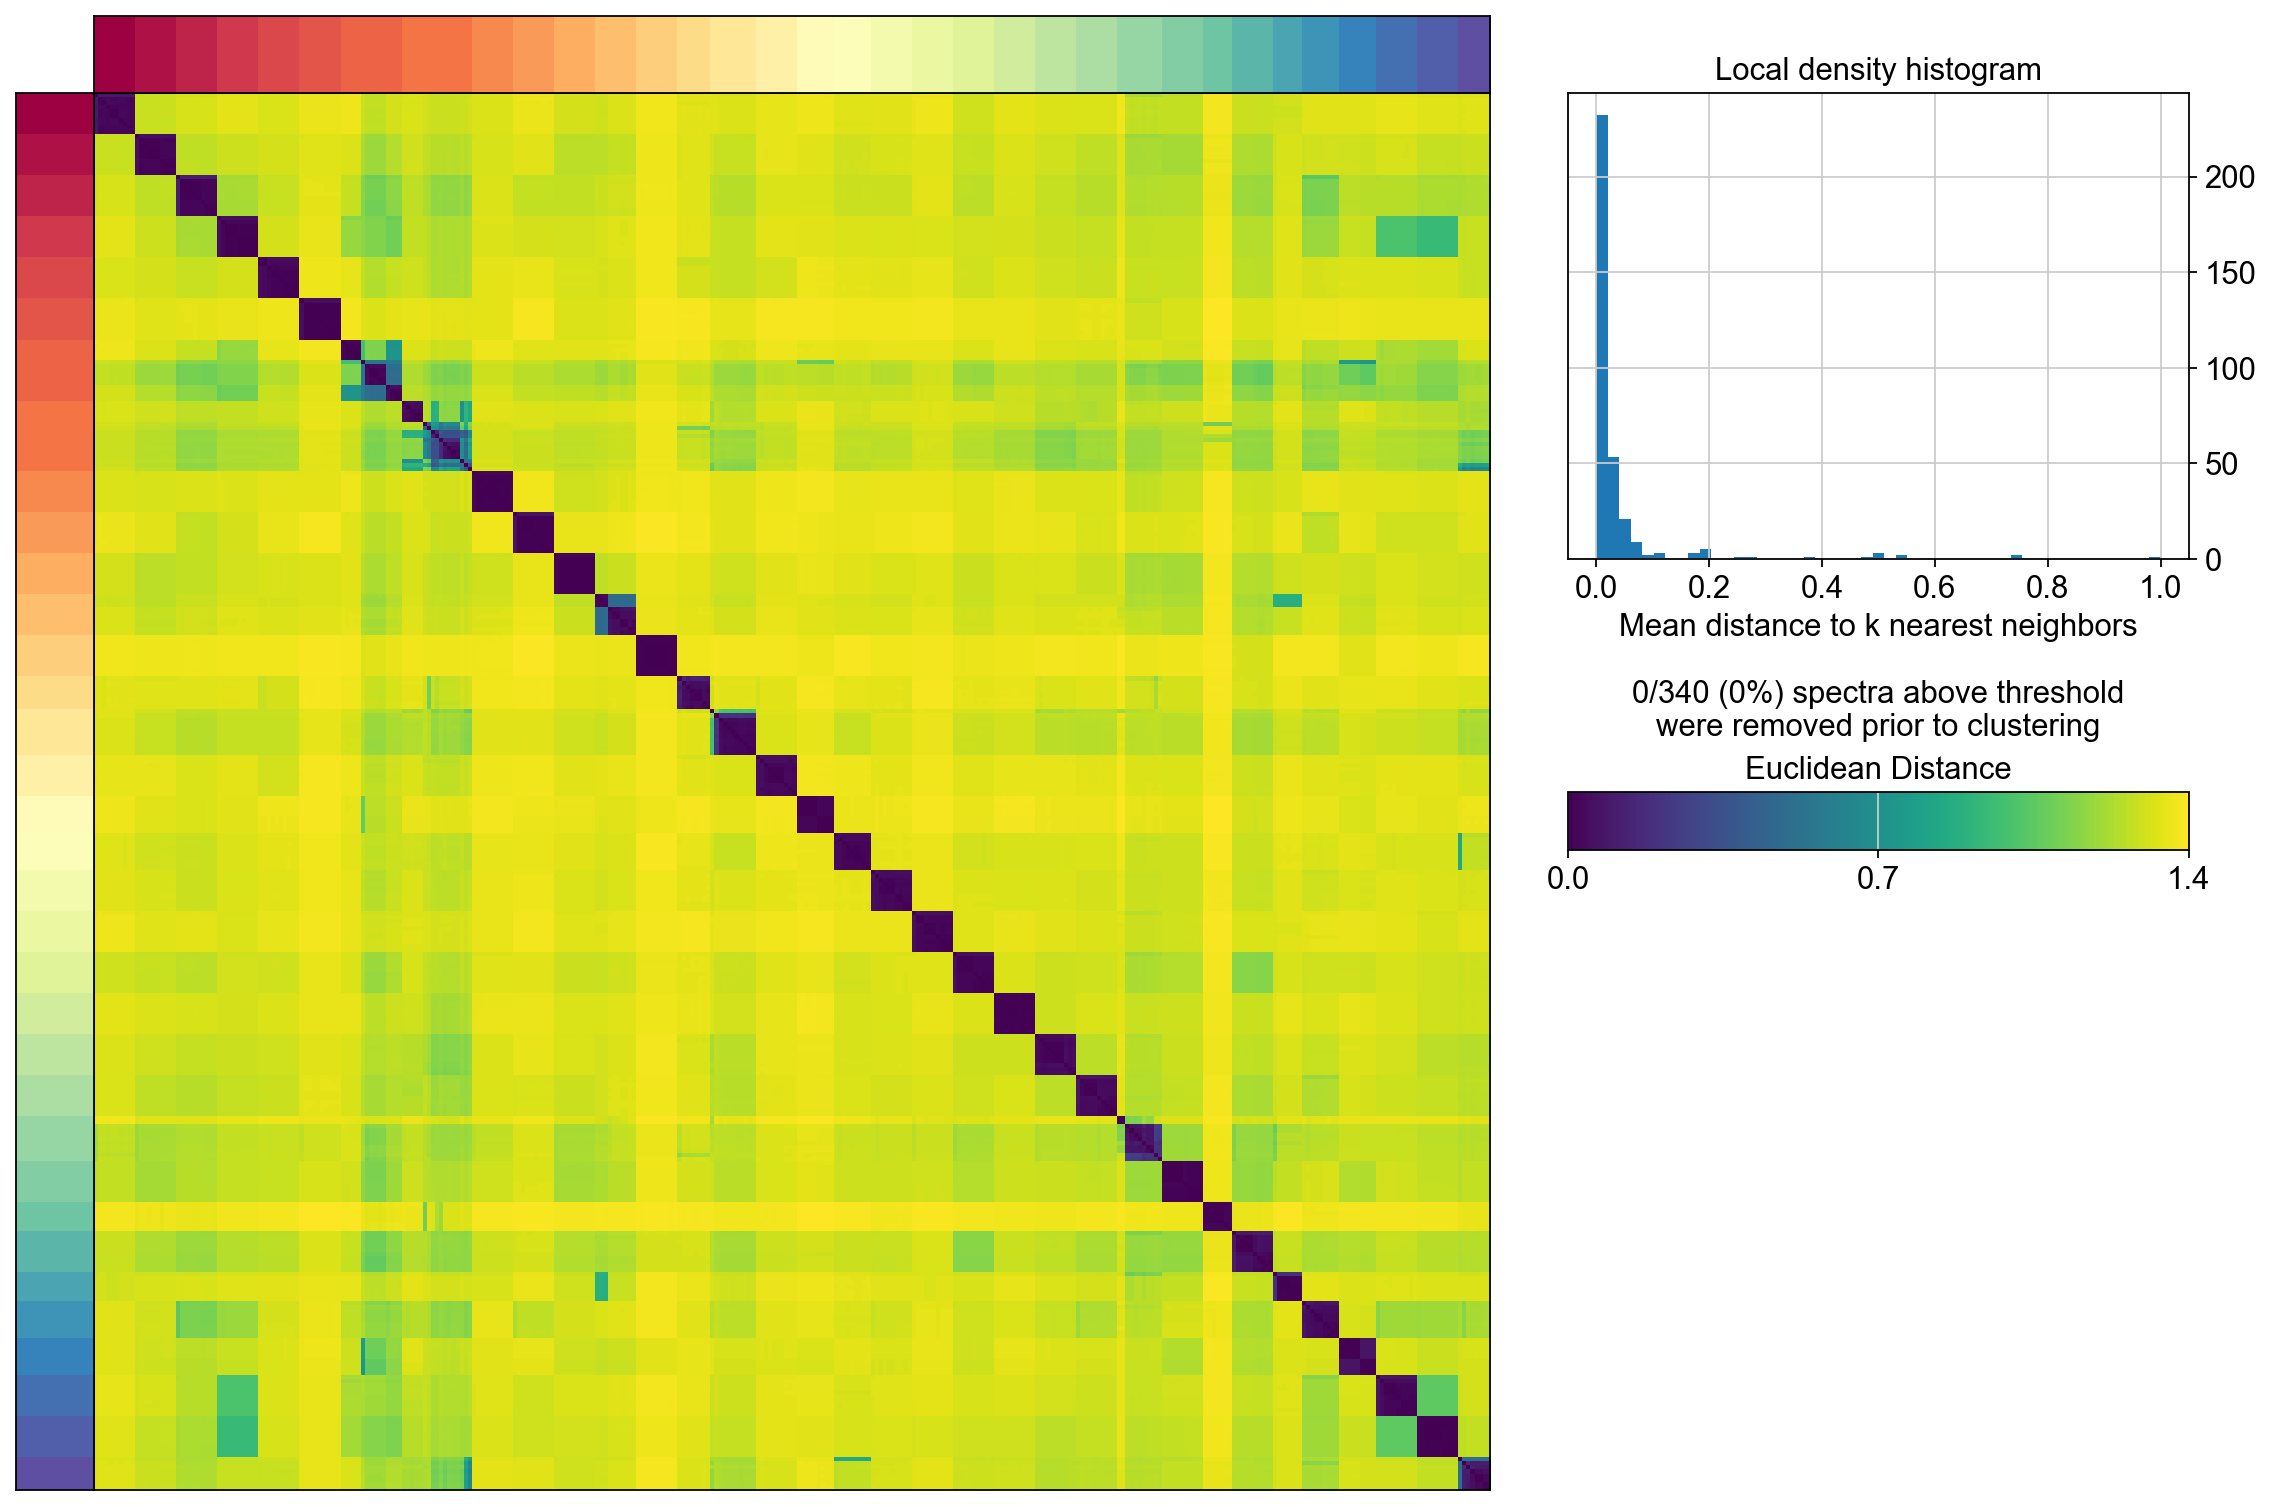

In [47]:
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)

In [48]:
density_threshold = 0.1

/hpc/mydata/madhav.mantri/conda_envs/cnmf/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


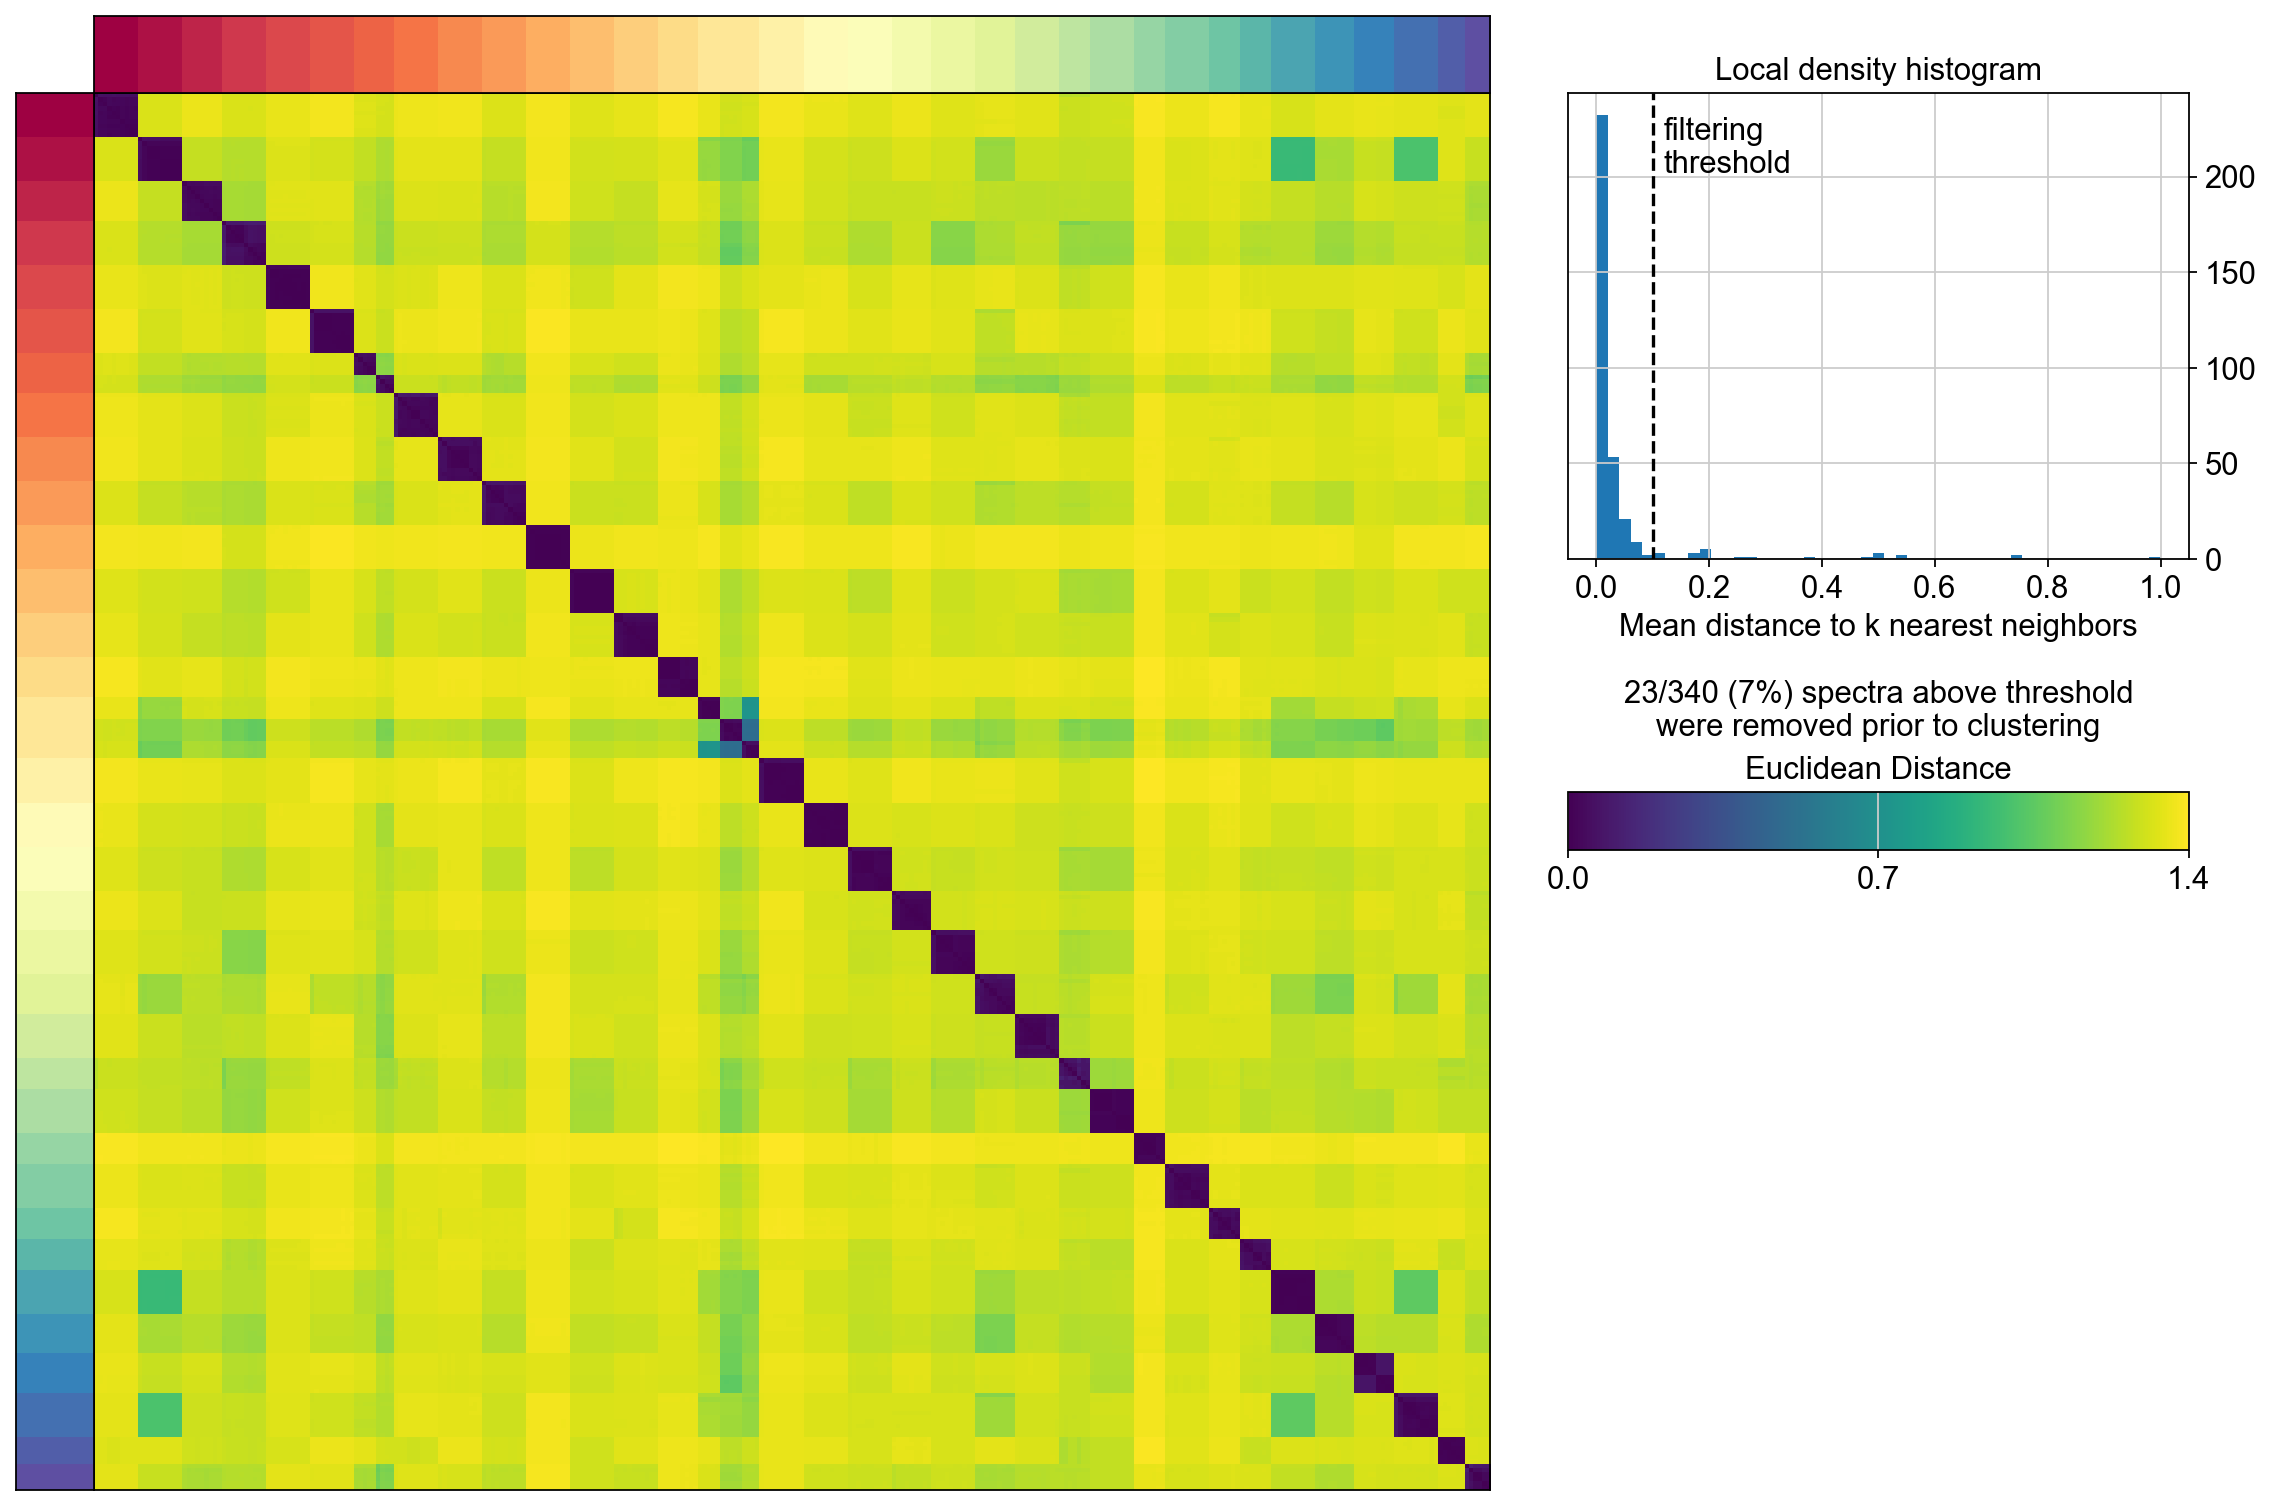

In [49]:
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)

In [50]:
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)
usage_norm.columns = ['Usage_%d' % i for i in usage_norm.columns]
usage_file = cnmf_obj.paths['consensus_usages__txt'] % (selected_K, '0_1')
print(usage_file)
gene_scores_file = cnmf_obj.paths['gene_spectra_score__txt'] % (selected_K, '0_1')
print(gene_scores_file)
gene_tpm_file = cnmf_obj.paths['gene_spectra_tpm__txt'] % (selected_K, '0_1')
print(gene_tpm_file)
topgenes.to_csv("./../tabula_sapiens/cNMF/" + run_name + "/" + run_name + ".topgenes.k_" + str(selected_K) + ".dt_0_1.csv")

/hpc/projects/group.quake/mmantri/tabula_immunosenescence/tabula_sapiens/cNMF/TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc/TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc.usages.k_34.dt_0_1.consensus.txt
/hpc/projects/group.quake/mmantri/tabula_immunosenescence/tabula_sapiens/cNMF/TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc/TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc.gene_spectra_score.k_34.dt_0_1.txt
/hpc/projects/group.quake/mmantri/tabula_immunosenescence/tabula_sapiens/cNMF/TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_bro

In [51]:
topgenes

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,CEACAM6,DDX5,RPN2,PLD3,AKR1B10,SERPING1,PSMC2,TSPAN1,LYPD3,TNFRSF11B,...,SPARC,VWA5A,CXCL1,RHBDD2,LITAF,C2orf68,ADH1B,ATP5PB,ACTB,MMUT
1,TCN1,ACTB,MYDGF,CTSD,ADH7,C1R,POLR2E,EFHC1,CLDN4,SPARC,...,ISLR,IDH3B,NAPEPLD,TMEM9B,PGK1,GAS8,LGALS3BP,CBR1,DAZAP2,MRPL22
2,DSG2,ARHGDIB,LMAN2,CTSB,S100A16,TMEM176A,XRCC6,DNALI1,TACSTD2,FN1,...,MAGED2,NUBP2,SUMO1,BRAP,SEPHS2,ATP6AP2,VPS35,C1orf43,SLC25A11,MAP2K6
3,KRT8,COMMD8,TMED2,CYP27A1,LYPD3,SPARC,COQ9,IFT22,C1orf116,EFEMP1,...,PGRMC1,NF2,SRP9,CCNG1,RBBP7,TSPAN31,MRPS14,RDH11,ISCA1,RBBP7
4,SPINT1,DAZAP2,TMEM59,PSAP,TPI1,ADH1B,GAS8,CALM2,SERPINB2,BGN,...,COL1A1,COPS7A,TCEAL8,GAS8,AAMP,KIN,TMEM68,SLC39A6,ENO1,PDHB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AFDN,TSPYL1,PSMD13,ATP6AP2,ENTPD3,TMEM109,FLOT1,TSC22D1,NECTIN4,SERINC1,...,ADRM1,SET,TIMP1,SRSF7,APLP2,GLTP,ADAR,NQO1,RBM17,PNKD
96,SH3BGRL2,LDLRAP1,TMED4,PFN1,RNH1,ANXA5,TMBIM6,PSMB5,S100A11,HTRA1,...,DFFA,DANCR,SERINC3,MTRFR,NUDT5,PSME1,C2orf68,ADAR,RNF34,FBXO22
97,SORBS2,JKAMP,BIRC3,CTSL,RHOD,AP2M1,DFFA,IFT88,GPR87,OAT,...,LONRF2,KMT2A,DHRS4,PSMC3,TIMM17B,LAPTM4A,HNRNPK,PHB1,GAPDH,EBNA1BP2
98,MAGI1,RNPS1,ECH1,ATP6V1A,OVOL1,FBXL15,AGO2,MAP9,PPP2R1A,MRFAP1,...,FKBP1A,ID2,CALU,VAT1,GNPTG,TUBA1A,TTC1,FGFR3,SF3B5,GINM1


In [52]:
! ls ./../tabula_sapiens/cNMF/{run_name}/

cnmf_tmp
TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc.clustering.k_34.dt_0_1.png
TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc.clustering.k_34.dt_2_0.png
TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc.gene_spectra_score.k_34.dt_0_1.txt
TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc.gene_spectra_score.k_34.dt_2_0.txt
TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc.gene_spectra_tpm.k_34.dt_0_1.txt
TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by